<a href="https://www.kaggle.com/code/thirumani/predicting-bigg-boss-telugu-season-6-winner?scriptVersionId=109646739" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Predicting Telugu Bigg Boss (బిగ్ బాస్ తెలుగు) 6 Season Winner

## Dataset https://www.kaggle.com/datasets/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
from IPython.display import IFrame
import datetime
print("Notebook was last executed on:", datetime.date.today().strftime("%Y-%b-%d"))

Notebook was last executed on: 2022-Oct-31


In [2]:
# Source: Wikipedia
IFrame('https://upload.wikimedia.org/wikipedia/en/6/63/BIGG_BOSS_TELUGU.jpg', width=560, height=240)

### Importing Required Python Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [4]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 162516 Oct 31 13:42 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 935 rows and 26 columns in the dataset


## Exploratory Data Analysis (EDA)

In [5]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3.0,0.0,0.0,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6.0,0.0,0.0,NaN,1.0,0.0


In [6]:
bigg_boss.tail(10).T

,925,926,927,928,929,930,931,932,933,934
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,4,4,4,4,4,4,4,4,4,4
Name,Naveen Arakkal,Nimisha,Robin Radhakrishnan,Ronson Vincent,Shalini Nair,Sooraj Thelakkad,Suchithra Nair,Manikandan Thonnakkal,Riyas Salim,Vinay Madhav
Profession,Soap Actor,Model,Doctor,Soap Actor,Video Jockey,Actor,Soap Actress,Social Media Star,Social Media Star,Social Media Star
Gender,Male,Female,Male,Male,Female,Male,Female,Male,Male,Male
Entry Date,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,5.0,7.0,10.0,13.0,3.0,14.0,9.0,4.0,14.0,12.0
Wild Card,No,No,No,No,No,No,No,Yes,Yes,Yes
Season Length,98,98,98,98,98,98,98,98,98,98


In [7]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
851,Bengali,2,Srabanti Banerjee,Actress,Female,04-Apr-16,NaN,NaN,No,97,16,04-Apr-16,15-Jul-16,Mithun Chakraborthy,NaN,0,Colors Bangla,6.50,West Bengal,No,1.0,0.0,0.0,NaN,0.0,0.0
657,Tamil,2,Ramya NSK,Singer,Female,17-Jun-18,NaN,5.0,No,105,17,17-Jun-18,30-Sep-18,Kamal Haasan,NaN,0,Star Vijay,8.20,Tamil Nadu,No,1.0,0.0,0.0,NaN,0.0,0.0
180,Hindi,10,Rohan Mehra,Soap Actor,Male,16-Oct-16,24-Jan-17,15.0,No,105,18,16-Oct-16,28-Jan-17,Salman Khan,NaN,0,Colors,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6.0,0.0,2.0,NaN,0.0,0.0
296,Hindi,15,Vishal Kotian,Soap Actor,Male,02-Oct-21,NaN,8.0,No,121,24,02-Oct-21,30-Jan-22,Salman Khan,NaN,0,Colors,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6.0,0.0,0.0,NaN,0.0,0.0
897,Malayalam,3,Adoney John,Activist,Male,14-Feb-21,NaN,11.0,No,95,19,14-Feb-21,20-May-21,Mohanlal,NaN,0,Asianet,12.40,Kerala,No,4.0,0.0,1.0,NaN,0.0,0.0
458,Kannada,8,Rajeev Hanu,Actor,Male,28-Feb-21,NaN,8.0,No,117,20,28-Feb-21,08-Aug-21,Sudeep,NaN,0,Colors Kannada,NaN,Karnataka,No,4.0,0.0,1.0,NaN,0.0,0.0
492,Kannada,9,Mayuri Kyatari,Actress,Female,24-Sep-22,NaN,4.0,No,105,18,24-Sep-22,07-Jan-23,Sudeep,NaN,0,"Colors Kannada, Voot",NaN,Karnataka,No,4.0,0.0,0.0,NaN,0.0,0.0
142,Hindi,Halla Bol,Mahek Chahal,Actress,Female,04-Jan-15,NaN,3.0,No,28,10,04-Jan-15,31-Jan-15,Farah Khan,NaN,0,Colors,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1.0,0.0,0.0,NaN,0.0,0.0
595,Telugu,Non-Stop,Bindu Madhavi,Actress,Female,26-Feb-22,NaN,NaN,No,84,18,26-Feb-22,21-May-22,Nagarjuna,NaN,"40,00,000",Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Yes,8.0,0.0,0.0,10.0,1.0,1.0
221,Hindi,12,Surbhi Rana,Commoner - Doctor,Female,NaN,30-Dec-18,15.0,Yes,105,20,16-Sep-18,30-Dec-18,Salman Khan,NaN,0,Colors,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4.0,1.0,5.0,NaN,0.0,0.0


In [8]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language                            935 non-null    object 
 1   Season Number                       935 non-null    object 
 2   Name                                935 non-null    object 
 3   Profession                          935 non-null    object 
 4   Gender                              935 non-null    object 
 5   Entry Date                          810 non-null    object 
 6   Elimination Date                    175 non-null    object 
 7   Elimination Week Number             741 non-null    float64
 8   Wild Card                           935 non-null    object 
 9   Season Length                       935 non-null    int64  
 10  Number of Housemates                935 non-null    int64  
 11  Season Start Date                   935 non-n

In [9]:
bigg_boss.describe().T.round(2).style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
Elimination Week Number,741.000000,8.810000,4.840000,1.000000,4.000000,9.000000,13.000000,20.000000
Season Length,935.000000,99.570000,18.420000,28.000000,98.000000,105.000000,105.000000,143.000000
Number of Housemates,935.000000,18.350000,2.440000,10.000000,17.000000,18.000000,20.000000,24.000000
Average TRP,531.000000,8.710000,5.550000,2.720000,3.810000,7.640000,12.400000,20.100000
Number of Evictions Faced,915.000000,4.040000,2.910000,0.000000,2.000000,3.000000,6.000000,17.000000
Number of re-entries,873.000000,0.080000,0.290000,0.000000,0.000000,0.000000,0.000000,3.000000
Number of times elected as Captain,853.000000,0.540000,0.730000,0.000000,0.000000,0.000000,1.000000,5.000000
Social Media Popularity,142.000000,7.090000,1.610000,2.000000,6.000000,7.000000,8.000000,10.000000
Finalist,857.000000,0.260000,0.440000,0.000000,0.000000,0.000000,1.000000,1.000000
Winner,865.000000,0.050000,0.220000,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [11]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            935 non-null    object        
 1   Season Number                       935 non-null    object        
 2   Name                                935 non-null    object        
 3   Profession                          935 non-null    object        
 4   Gender                              935 non-null    object        
 5   Entry Date                          810 non-null    datetime64[ns]
 6   Elimination Date                    175 non-null    datetime64[ns]
 7   Elimination Week Number             741 non-null    Int32         
 8   Wild Card                           935 non-null    object        
 9   Season Length                       935 non-null    int64         
 10  Number of Housemates      

In [12]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col, "-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 20
Number of unique values in Name - 879
Number of unique values in Profession - 84
Number of unique values in Gender - 4
Number of unique values in Entry Date - 61
Number of unique values in Elimination Date - 106
Number of unique values in Elimination Week Number - 20
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 20
Number of unique values in Number of Housemates - 12
Number of unique values in Season Start Date - 52
Number of unique values in Season End Date - 50
Number of unique values in Host Name - 14
Number of unique values in Guest Host Name - 6
Number of unique values in Prize Money (INR) - 15
Number of unique values in Broadcasted By - 15
Number of unique values in Average TRP - 28
Number of unique values in Most Viewed States - 7
Number of unique values in OTT Season - 2
Number of unique values in Number of Evictions Faced - 17
Number of unique values in N

In [13]:
# Number of seasons in all Indian languages
print("Total", bigg_boss.groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted (in TV & OTT)")
print(bigg_boss['Winner'].sum().astype(int)+1, "seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(), "season(s) running")

Total 52 seasons broadcasted (in TV & OTT)
47 seasons completed
5 season(s) running


In [14]:
# Seasons broadcasted ONLY in OTT platforms
print(bigg_boss.loc[bigg_boss['OTT Season']=='Yes'].groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted ONLY in OTT platforms")

4 seasons broadcasted ONLY in OTT platforms


## Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [15]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        18
Kannada      10
Tamil         7
Telugu        7
Malayalam     4
Marathi       4
Bengali       2
Name: Season Number, dtype: int64


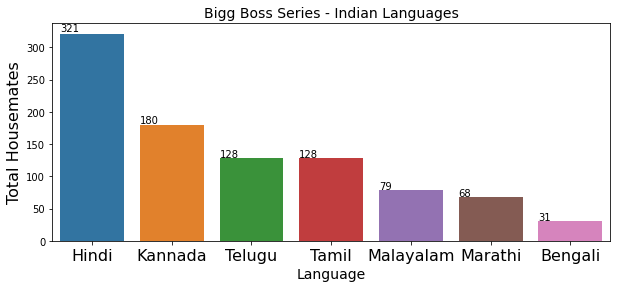

In [16]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Languages', fontsize=14)
plt.xticks(fontsize=16)
plt.xlabel("Language", fontsize=14)
plt.ylabel("Total Housemates", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates entered in first day/week

No     799
Yes    136
Name: Wild Card, dtype: int64 

No     85%
Yes    15%
Name: Wild Card, dtype: object 



<AxesSubplot:ylabel='Wild Card'>

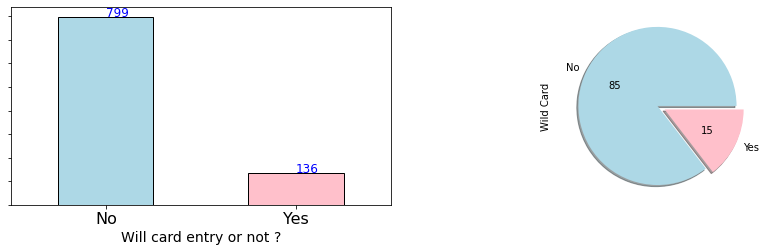

In [17]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss['Wild Card'].value_counts().plot(kind='bar',color=["lightblue","pink"],ec="k")
plt.xlabel("Will card entry or not ?", fontsize=14)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss['Wild Card'].value_counts()):
    plt.annotate(y,(x,y),fontsize=12,color="blue")
    
ax2=plt.subplot(222)
bigg_boss['Wild Card'].value_counts().plot(kind='pie',autopct='%.0f',explode = (0,0.10),colors=["lightblue","pink"],shadow=True)

In [18]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession'] = 'Commoner'

## Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Actress                  206
Actor                    144
Soap Actress              78
Model                     67
Singer                    58
Soap Actor                50
Commoner                  43
Social Media Star         31
TV Anchor                 28
Reality Show Alumni       27
Comedian                  24
Radio Jockey              20
Choreographer             18
News Presenter            16
Sports Person              9
Activist                   9
Video Jockey               9
Film Director              8
Pageant Winner             7
International Star         6
Politician                 6
Producer                   5
Dancer                     5
LGBT                       4
Swamiji                    4
Controversial Fame         4
Musician                   3
Numerologist               3
Wrestler                   3
Stage Actress              2
Doctor                     2
Lyricist                   2
Entrepreneur               2
Journalist                 2
Film director 

Text(0, 0.5, 'Count')

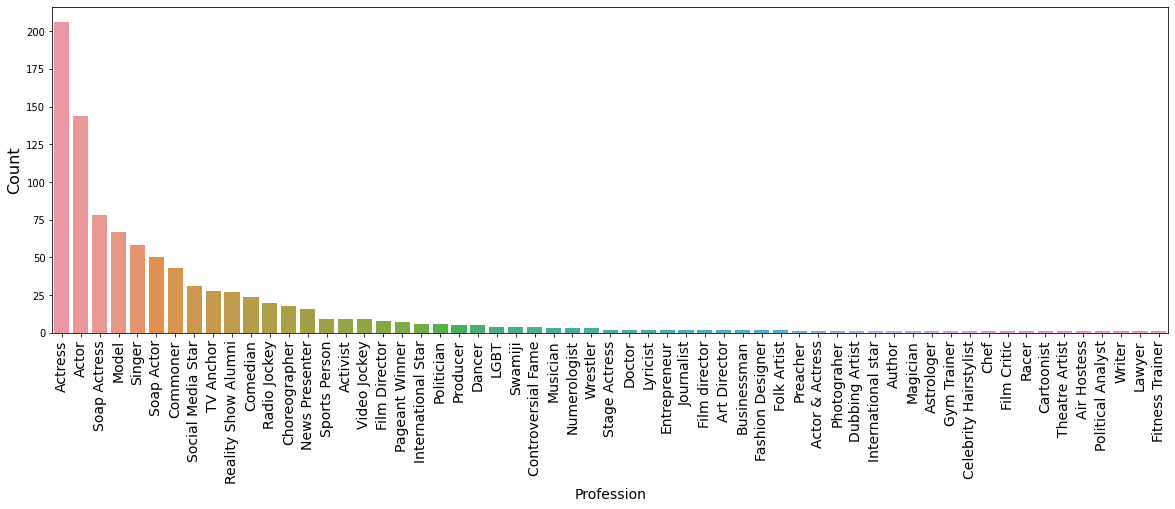

In [19]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20, 6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(fontsize=14, rotation=90)
plt.xlabel("Profession", fontsize=14)
plt.ylabel("Count", fontsize=16)

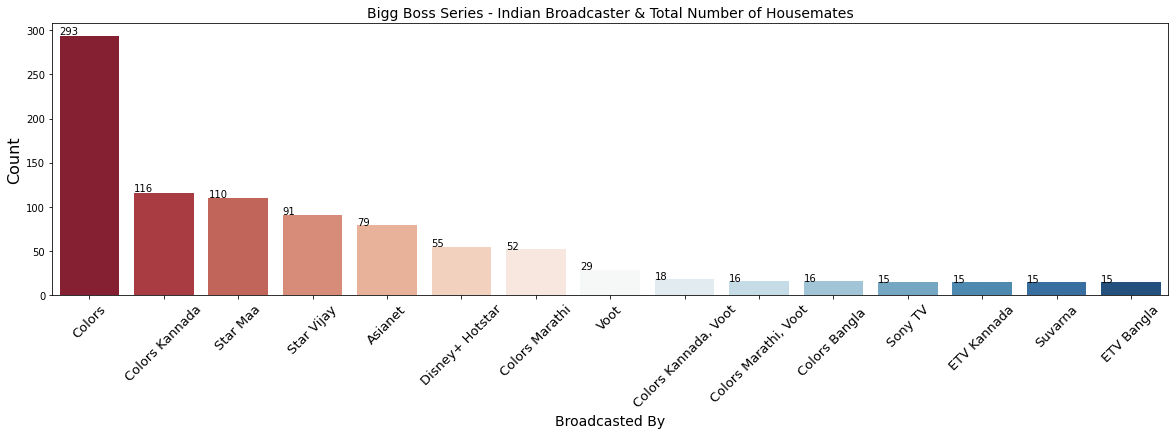

In [20]:
# Broadcaster
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Broadcaster & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=13, rotation=45)
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("Count", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

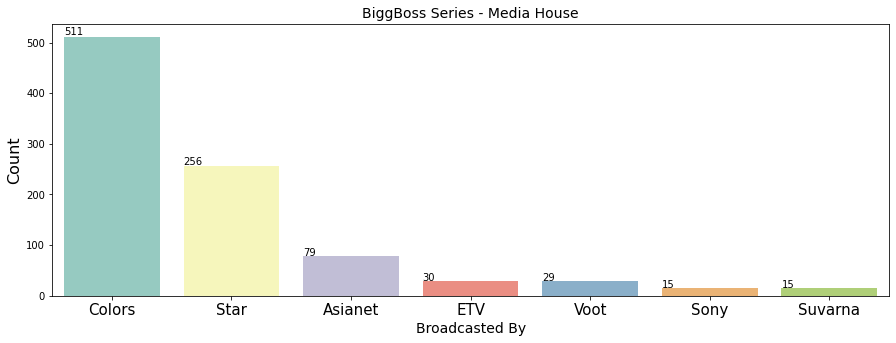

In [21]:
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star'), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star').value_counts().index)
ax.set_title('BiggBoss Series - Media House', fontsize=14)
plt.xticks(fontsize=15)
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("Count", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [22]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            13
Sudeep                 10
Kamal Haasan            7
Nagarjuna               5
Mahesh Manjrekar        4
Mohanlal                4
Mithun Chakraborthy     2
Amitabh Bachchan        1
Arshad Warsi            1
Farah Khan              1
Jr. NTR                 1
Karan Johar             1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [23]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Samantha             1
Sanjay Dutt          1
Siddhartha Jadhav    1
Simbu                1
Name: Season Number, dtype: int64

## In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Female         486
Male           441
Transgender      7
Couple           1
Name: Gender, dtype: int64 

Female         52%
Male           47%
Transgender     1%
Couple          0%
Name: Gender, dtype: object


Text(0, 0.5, 'Count')

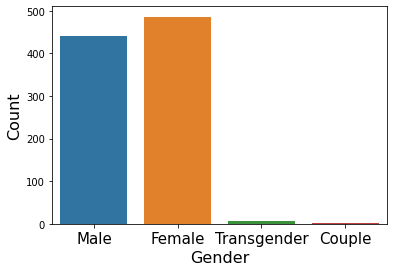

In [24]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

sns.countplot(data = bigg_boss, x = 'Gender')
plt.xticks(fontsize=15)
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Count", fontsize=16)

### Only 7 Transgenders (LGBT) participated in all Indian languages

In [25]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP", bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language Season Number
  Telugu             4


In [26]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season", bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 28 days 

Language Season Number
   Hindi     Halla Bol


In [27]:
# Longest season of Bigg Boss Indian seasons
print("Longest season", bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 143 days 

Language Season Number
   Hindi            14


## Shark Tank India data set https://www.kaggle.com/datasets/thirumani/shark-tank-india

In [28]:
print("Maximum number of contestants in one season:", bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 24 

Language Season Number
   Hindi            15


In [29]:
print("Maximum number of evictions faced in one season:", bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 3 contestants who faced maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-3][["Language","Season Number","Name","Number of Evictions Faced"]].head(3).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 17 


Top 3 contestants who faced maximum number of evictions

Language Season Number               Name  Number of Evictions Faced
   Hindi            14      Rubina Dilaik                         17
 Kannada             8 Prashanth Sambargi                         15
   Hindi            14       Rahul Vaidya                         14


In [30]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:", bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-15][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(5).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 100 %


Top 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Language Season Number               Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
   Hindi     Halla Bol      Dimpy Ganguly                          4                       4                         100
 Kannada           OTT Jayashree Aradhaya                          6                       6                         100
  Telugu      Non-Stop     Mitraaw Sharma                         11                      12                          92
 Kannada             8 Prashanth Sambargi                         15                      17                          88
   Hindi            14      Rubina Dilaik                         17                      20                          85


In [31]:
print("Maximum number of re-entries:", bigg_boss['Number of re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of re-entries']>=bigg_boss['Number of re-entries'].max()-1][["Language","Season Number","Name","Number of re-entries"]].head(5).sort_values("Number of re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 3 

Language Season Number         Name  Number of re-entries
   Hindi            14  Vikas Gupta                     3
  Telugu             1 Mumaith Khan                     2
  Telugu             2  Nutan Naidu                     2


In [32]:
print("Maximum number of times elected as captain:", bigg_boss['Number of times elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of times elected as Captain']>=bigg_boss['Number of times elected as Captain'].max()-1][["Language","Season Number","Name","Number of times elected as Captain"]].head(6).sort_values("Number of times elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

 Language Season Number           Name  Number of times elected as Captain
    Hindi            12    Surbhi Rana                                   5
    Hindi             9  Prince Narula                                   4
    Hindi            10 Manveer Gurjar                                   4
Malayalam             2  Saju Navodaya                                   4


In [33]:
# Many contestants entered via wild card, but 24 people managed to go to Finale
print(bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Finalist'].value_counts())
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

1    24
Name: Finalist, dtype: Int64


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,NaT,NaT,12,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,1,0.0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,2,0,2,<NA>,1,0.0,14,14
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,1,<NA>,1,0.0,14,29
75,Hindi,5,Amar Upadhyay,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,1,<NA>,1,0.0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,5,0,0,<NA>,1,0.0,14,36
77,Hindi,5,Akashdeep Saigal,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,5,0,1,<NA>,1,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,1,1,<NA>,1,0.0,14,43
115,Hindi,7,Ajaz Khan,Actor,Male,NaT,2013-12-28,15,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,0,<NA>,1,0.0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,1,<NA>,1,0.0,15,40
135,Hindi,8,Dimpy Ganguly,TV Anchor,Female,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,5,0,1,<NA>,1,0.0,15,33


In [34]:
# Number of Wild card entries went to Finale, as per Language
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Language'].value_counts()

Hindi        14
Tamil         4
Telugu        2
Marathi       2
Malayalam     2
Name: Language, dtype: int64

In [35]:
# Persons who participated in more than one season (in same/different languages)
print(bigg_boss.groupby('Name')['Season Number'].nunique().nlargest(53))
bigg_boss[bigg_boss.groupby('Name')['Season Number'].transform('size')>1] [["Name", "Language", "Season Number"]].sort_values(by=['Name','Season Number'], ascending=True)

Name
Rakhi Sawant               3
Shamita Shetty             3
Vikas Gupta                3
Abhinay Vaddi              2
Abhirami Venkatachalam     2
Ajaz Khan                  2
Akhil Sarthak              2
Ali Quli Mirza             2
Anitha Sampath             2
Anupama Gowda              2
Ariyana Glory              2
Arshi Khan                 2
Arun Sagar                 2
Aryavardhan Guruji         2
Ashu Reddy                 2
Baba Bhaskar               2
Balaji Murugadoss          2
Bindu Madhavi              2
Deepika Das                2
Devoleena Bhattacharjee    2
Dimpy Ganguly              2
Divya Uruduga Rajeev       2
Gautam Gulati              2
Hamida Khatoon             2
Karishma Tanna             2
Mahek Chahal               2
Mahesh Vitta               2
Manu Punjabi               2
Maria Juliana              2
Megha Dhade                2
Mumaith Khan               2
Nataraj                    2
Neha Bhasin                2
Neha Gowda                 2
Nishant B

,Name,Language,Season Number
700,Abhinay Vaddi,Tamil,5
720,Abhinay Vaddi,Tamil,Ultimate
665,Abhirami Venkatachalam,Tamil,3
721,Abhirami Venkatachalam,Tamil,Ultimate
115,Ajaz Khan,Hindi,7
...,...,...,...
679,Vanitha Vijayakumar,Tamil,3
733,Vanitha Vijayakumar,Tamil,Ultimate
201,Vikas Gupta,Hindi,11
245,Vikas Gupta,Hindi,13


In [36]:
# Persons who participated in more than one language
bigg_boss.groupby('Name')['Language'].nunique().nlargest(2)

Name
Bindu Madhavi    2
Megha Dhade      2
Name: Language, dtype: int64

In [37]:
# 16 housemates eliminated or walked without facing even single nomination 
print(bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), 'Number of Evictions Faced'].value_counts())
bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), :]

0    23
Name: Number of Evictions Faced, dtype: Int64


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,0,<NA>,0,0.0,12,0
19,Hindi,2,Jade Goody,International Star,Female,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,0,<NA>,0,0.0,14,0
39,Hindi,3,Shamita Shetty,Actress,Female,2009-10-04,NaT,<NA>,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,0,<NA>,0,0.0,12,0
73,Hindi,5,Sonika Kaliraman,Wrestler,Female,2011-10-02,NaT,<NA>,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,0,<NA>,0,0.0,14,0
152,Hindi,9,Kishwar Merchant,Soap Actress,Female,2015-10-11,NaT,<NA>,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,2,<NA>,0,0.0,15,0
245,Hindi,13,Vikas Gupta,Producer,Male,NaT,NaT,13,Yes,140,22,2019-09-29,2020-02-15,Salman Khan,NaN,0.0,Colors,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,1,<NA>,0,0.0,20,0
298,Hindi,15,Raqesh Bapat,Actor,Male,NaT,NaT,6,Yes,121,24,2021-10-02,2022-01-30,Salman Khan,NaN,0.0,Colors,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,0,<NA>,0,0.0,17,0
302,Hindi,15,Rakhi Sawant,Actress,Female,NaT,NaT,17,Yes,121,24,2021-10-02,2022-01-30,Salman Khan,NaN,0.0,Colors,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,0,0,0,<NA>,0,0.0,17,0
353,Kannada,3,Huccha Venkat,Actor,Male,2015-10-25,NaT,<NA>,No,98,18,2015-10-25,2016-01-31,Sudeep,NaN,0.0,Colors Kannada,NaN,Karnataka,No,0,0,0,<NA>,0,0.0,14,0
404,Kannada,5,Vaishnavi Chandran Menon,Actress,Female,NaT,NaT,15,Yes,106,20,2017-10-15,2018-01-28,Sudeep,NaN,0.0,Colors Kannada,NaN,Karnataka,No,0,0,0,<NA>,0,0.0,15,0


In [38]:
# Only one couple entered (as pair) into BB houses
bigg_boss.loc[(bigg_boss['Gender']=="Couple"), :]

# Many other couples entered into Bigg Boss, but as individual contestants

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
911,Malayalam,3,Firoz Khan & Sajna Firoz,Actor & Actress,Couple,NaT,NaT,9,Yes,95,19,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,Kerala,No,7,0,0,<NA>,0,0.0,14,50


## About Winners only

In [39]:
print("Total Bigg Boss season winners", bigg_boss['Winner'].sum().astype(int), "(out of", bigg_boss['Finalist'].sum(), "finalists)")
# For Malayalam Season 2 winner was not declared

Total Bigg Boss season winners 46 (out of 224 finalists)


In [40]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,<NA>,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,1,1.0,12,33
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,1,1.0,14,29
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,<NA>,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,0,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,<NA>,No,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,2,<NA>,1,1.0,14,29
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,<NA>,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,1,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,<NA>,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,1,<NA>,1,1.0,14,43
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,<NA>,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,2,<NA>,1,1.0,15,47
121,Hindi,8,Gautam Gulati,Actor,Male,2014-09-21,NaT,<NA>,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,5000000.0,Colors,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,10,0,1,<NA>,1,1.0,15,67
140,Hindi,Halla Bol,Gautam Gulati,Actor,Male,2015-01-04,NaT,<NA>,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,2,0,0,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,<NA>,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,4,<NA>,1,1.0,15,40


In [41]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 24 crores and 11 lakh rupees

₹24,11,00,000


In [42]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Profession'].value_counts()

Actor                  12
Soap Actress            7
Actress                 7
Singer                  4
Reality Show Alumni     3
Soap Actor              3
Commoner                2
TV Anchor               2
Model                   2
Film Director           1
Comedian                1
Radio Jockey            1
Video Jockey            1
Name: Profession, dtype: int64

Male      32
Female    14
Name: Gender, dtype: int64 

Male      %%
Female    %%
Name: Gender, dtype: object


<AxesSubplot:ylabel='Gender'>

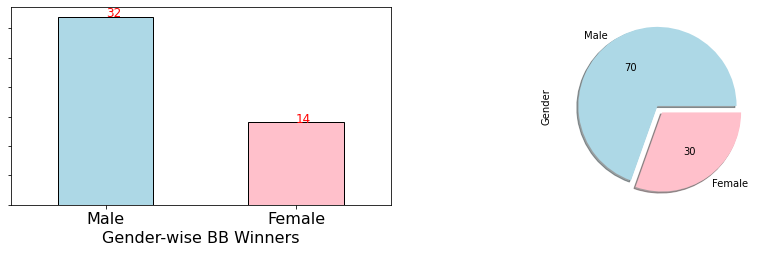

In [43]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Gender-wise BB Winners", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts()):
    plt.annotate(y,(x,y),fontsize=12,color="Red")
    
ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='pie',autopct='%.0f',explode = (0, 0.10),colors=["lightblue","pink"],shadow=True)

## No wild card entry housemate won the Bigg Boss competition.

In [44]:
# Entry type (wildcard or not) of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Wild Card'].value_counts()

No    46
Name: Wild Card, dtype: int64

In [45]:
bigg_boss.loc[bigg_boss.Winner==1, 'Season Length'].value_counts().sort_index()

# Length of the season - Number of Winners

28      1
42      2
70      2
84      2
86      1
90      1
95      1
96      1
97      2
98     11
100     1
105    12
106     2
112     2
113     1
117     1
121     1
140     1
143     1
Name: Season Length, dtype: int64

In [46]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

10    1
13    1
15    6
16    5
17    5
18    9
19    7
20    9
22    2
24    1
Name: Number of Housemates, dtype: int64

In [47]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

2     2
4     7
5     6
6     6
7     8
8     2
9     7
10    1
11    2
12    3
17    1
Name: Number of Evictions Faced, dtype: Int64

In [48]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1, 'Number of re-entries'].value_counts()

0    46
Name: Number of re-entries, dtype: Int64

In [49]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1, 'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

0    14
1    14
2    13
3     1
4     2
Name: Number of times elected as Captain, dtype: Int64

## BB Telugu Seasons

In [50]:
lang='Telugu'

# All Bigg Boss Telugu Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
501,Telugu,1,Aadarsh Balakrishna,Actor,Male,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,4,0,1,7,1,0.0,10,40
502,Telugu,1,Archana,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,6,0,0,5,1,0.0,10,60
503,Telugu,1,Dhanraj,Comedian,Male,2017-07-16,2017-08-26,6,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,3,0,0,<NA>,0,0.0,10,30
504,Telugu,1,Hari Teja,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,6,0,1,5,1,0.0,10,60
505,Telugu,1,Jyothi,Actress,Female,2017-07-16,2017-07-23,1,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,1,0,0,<NA>,0,0.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,Telugu,6,Shani Salmon,Actor,Male,2022-09-04,2022-09-17,2,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0.0,Star Maa,NaN,"Telangana, Andhra Pradesh",No,1,0,0,<NA>,0,0.0,15,7
625,Telugu,6,Sri Satya,Soap Actress,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,6,0,0,<NA>,<NA>,NaN,15,40
626,Telugu,6,Srihan,Social Media Star,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,5,0,1,<NA>,<NA>,NaN,15,33
627,Telugu,6,Sudeepa Pinky,Actress,Female,2022-09-04,2022-10-16,6,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0.0,Star Maa,NaN,"Telangana, Andhra Pradesh",No,4,0,0,<NA>,0,0.0,15,27


In [51]:
# Bigg Boss Telugu Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
514,Telugu,1,Siva Balaji,Actor,Male,2017-07-16,NaT,<NA>,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,4,0,2,8,1,1.0,10,40
524,Telugu,2,Kaushal Manda,Actor,Male,2018-06-10,NaT,<NA>,No,112,18,2018-06-10,2018-09-30,Nani,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,11,0,1,10,1,1.0,16,69
543,Telugu,3,Rahul Sipligunj,Singer,Male,2019-07-21,NaT,<NA>,No,105,17,2019-07-21,2019-11-03,Nagarjuna,Ramya Krishnan,5000000.0,Star Maa,18.1,"Telangana, Andhra Pradesh",No,12,0,0,9,1,1.0,15,80
552,Telugu,4,Abijeet,Actor,Male,2020-09-06,NaT,<NA>,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha,2500000.0,Star Maa,20.1,"Telangana, Andhra Pradesh",No,12,0,0,9,1,1.0,15,80
586,Telugu,5,Sunny,Video Jockey,Male,2021-09-05,NaT,<NA>,No,105,19,2021-09-05,2021-12-19,Nagarjuna,NaN,5000000.0,Star Maa,18.2,"Telangana, Andhra Pradesh",No,9,0,1,10,1,1.0,15,60
595,Telugu,Non-Stop,Bindu Madhavi,Actress,Female,2022-02-26,NaT,<NA>,No,84,18,2022-02-26,2022-05-21,Nagarjuna,NaN,4000000.0,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Yes,8,0,0,10,1,1.0,12,67


In [52]:
# Telugu Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
501,Telugu,1,Aadarsh Balakrishna,Actor,Male,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,4,0,1,7,1,0.0,10,40
502,Telugu,1,Archana,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,6,0,0,5,1,0.0,10,60
504,Telugu,1,Hari Teja,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,6,0,1,5,1,0.0,10,60
514,Telugu,1,Siva Balaji,Actor,Male,2017-07-16,NaT,<NA>,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,4,0,2,8,1,1.0,10,40
516,Telugu,1,Navdeep,Actor,Male,2017-08-14,2017-09-24,10,Yes,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,3,0,1,9,1,0.0,10,30
520,Telugu,2,Deepti Nallamuthu,TV Anchor,Female,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,11,0,1,5,1,0.0,16,69
523,Telugu,2,Geetha Madhuri,Singer,Female,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,7,0,2,8,1,0.0,16,44
524,Telugu,2,Kaushal Manda,Actor,Male,2018-06-10,NaT,<NA>,No,112,18,2018-06-10,2018-09-30,Nani,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,11,0,1,10,1,1.0,16,69
528,Telugu,2,Samrat Reddy,Actor,Male,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,3,0,1,5,1,0.0,16,19
531,Telugu,2,Tanish Alladi,Actor,Male,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",No,5,0,2,7,1,0.0,16,31


In [53]:
# Number of finalists gender wise, in each BB Telugu season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

Gender  Season Number
Female  1                2
        2                2
        3                1
        4                2
        5                1
        Non-Stop         3
Male    1                3
        2                3
        3                4
        4                3
        5                4
        Non-Stop         4
Name: Season Number, dtype: int64

## Bigg Boss India data set visualizations/infographics at Tableau Public -
## http://public.tableau.com/app/profile/satya.thirumani/viz/BiggBossIndia_16434338263440/BBStory

In [54]:
IFrame('https://public.tableau.com/views/BiggBossIndia_16434338263440/BBStory?:language=en-US&:display_count=n&:origin=viz_share_link', width=1000, height=1000)

In [55]:
# Bigg Boss Telugu current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']=='6'), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
608,Telugu,6,Abhinaya Shree,Actress,Female,2022-09-04,2022-09-18,2,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0.0,Star Maa,NaN,"Telangana, Andhra Pradesh",No,2,0,0,<NA>,0,0.0,15,13
609,Telugu,6,Adi Reddy,Social Media Star,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,6,0,1,<NA>,<NA>,NaN,15,40
610,Telugu,6,Arjun Kalyan,Actor,Male,2022-09-04,2022-10-23,7,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0.0,Star Maa,NaN,"Telangana, Andhra Pradesh",No,4,0,0,<NA>,0,0.0,15,27
611,Telugu,6,Arohi Rao,TV Anchor,Female,2022-09-04,2022-10-02,4,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0.0,Star Maa,NaN,"Telangana, Andhra Pradesh",No,4,0,0,<NA>,0,0.0,15,27
612,Telugu,6,Bala Aditya,Actor,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,8,0,1,<NA>,<NA>,NaN,15,53
613,Telugu,6,Chalaki Chanti,Comedian,Male,2022-09-04,2022-10-09,5,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0.0,Star Maa,NaN,"Telangana, Andhra Pradesh",No,3,0,0,<NA>,0,0.0,15,20
614,Telugu,6,Faima,Comedian,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,6,0,0,<NA>,<NA>,NaN,15,40
615,Telugu,6,Geetu Royal,Social Media Star,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,6,0,0,<NA>,<NA>,NaN,15,40
616,Telugu,6,Inaya Sulthana,Actress,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,7,0,0,<NA>,<NA>,NaN,15,47
617,Telugu,6,Keerthi Bhat,Soap Actress,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,NaN,"Telangana, Andhra Pradesh",No,7,0,1,<NA>,<NA>,NaN,15,47


In [56]:
# Bigg Boss Telugu Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Female         66
Male           60
Transgender     2
Name: Gender, dtype: int64 



In [57]:
print("\nTop 7 Telugu contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-1)][["Season Number","Name","Number of Evictions Faced"]].head(8).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 7 Telugu contestants who faced maximum number of evictions

Season Number              Name  Number of Evictions Faced
            3   Rahul Sipligunj                         12
            4           Abijeet                         12
            4      Monal Gajjar                         12
            2 Deepti Nallamuthu                         11
            2     Kaushal Manda                         11
            5    Siri Hanumanth                         11
     Non-Stop    Mitraaw Sharma                         11


In [58]:
print("\nTop 3 Telugu contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-10)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(6).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top 3 Telugu contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Season Number           Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
     Non-Stop Mitraaw Sharma                         11                      12                          92
     Non-Stop  Ariyana Glory                         10                      12                          83
     Non-Stop          Shiva                         10                      12                          83


## Preparing Data for ML modelling

In [59]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                            125
Elimination Date                      760
Elimination Week Number               194
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                         0
Host Name                               0
Guest Host Name                       809
Prize Money (INR)                      70
Broadcasted By                          0
Average TRP                           404
Most Viewed States                      0
OTT Season                              0
Number of Evictions Faced              20
Number of re-entries                   62
Number of times elected as Captain     82
Social Media Popularity           

In [60]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [61]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [62]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            935 non-null    object        
 1   Season Number                       935 non-null    object        
 2   Name                                935 non-null    object        
 3   Profession                          935 non-null    object        
 4   Gender                              935 non-null    object        
 5   Entry Date                          810 non-null    datetime64[ns]
 6   Elimination Date                    175 non-null    datetime64[ns]
 7   Elimination Week Number             741 non-null    Int32         
 8   Wild Card                           935 non-null    object        
 9   Season Length                       935 non-null    int64         
 10  Number of Housemates      

In [63]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3,0,0,<NA>,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,LGBT,Transgender,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,0,<NA>,1,0.0,12,50,2006,2007,4,1


In [64]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
930,Malayalam,4,Sooraj Thelakkad,Actor,Male,2022-03-27,NaT,14,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,5,0,2,<NA>,1,0.0,14,36,2022,2022,1,3
931,Malayalam,4,Suchithra Nair,Soap Actress,Female,2022-03-27,NaT,9,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,2,0,0,<NA>,0,0.0,14,14,2022,2022,1,3
932,Malayalam,4,Manikandan Thonnakkal,Social Media Star,Male,NaT,NaT,4,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,0,0,0,<NA>,0,0.0,14,0,2022,2022,1,3
933,Malayalam,4,Riyas Salim,Social Media Star,Male,NaT,NaT,14,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,4,0,1,7,1,0.0,14,29,2022,2022,1,3
934,Malayalam,4,Vinay Madhav,Social Media Star,Male,NaT,NaT,12,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,8.707476,Kerala,No,5,0,0,<NA>,0,0.0,14,36,2022,2022,1,3


In [65]:
# Updating last week-end elimination/entries manually
# bigg_boss.iloc[614, 25] = 0

In [66]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
593,Telugu,Non-Stop,Ariyana Glory,TV Anchor,Female,2022-02-26,NaT,12,No,84,18,2022-02-26,2022-05-21,Nagarjuna,NaN,1000000.0,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",Yes,10,0,0,7,1,0.0,12,83,2022,2022,1,2
848,Bengali,2,Priya Paul,Soap Actress,Female,2016-04-04,NaT,<NA>,No,97,16,2016-04-04,2016-07-15,Mithun Chakraborthy,NaN,0.0,Colors Bangla,6.500000,West Bengal,No,11,0,1,<NA>,1,0.0,14,79,2016,2016,2,3
256,Hindi,14,Shehzad Deol,Model,Male,2020-10-03,2020-10-18,3,No,143,22,2020-10-03,2021-02-21,Salman Khan,NaN,0.0,Colors,8.707476,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,0,0.0,20,20,2020,2021,4,1
870,Malayalam,1,Sreelakshmi Sreekumar,Actress,Female,2018-06-24,NaT,4,No,98,18,2018-06-24,2018-09-30,Mohanlal,NaN,0.0,Asianet,10.330000,Kerala,No,2,0,0,<NA>,0,0.0,14,14,2018,2018,2,3
118,Hindi,8,Arya Babbar,Actor,Male,2014-09-21,NaT,8,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.770000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3,0,0,<NA>,0,0.0,15,20,2014,2015,3,1
601,Telugu,Non-Stop,Nataraj,Choreographer,Male,2022-02-26,NaT,11,No,84,18,2022-02-26,2022-05-21,Nagarjuna,NaN,0.0,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",Yes,7,0,1,<NA>,0,0.0,12,58,2022,2022,1,2
774,Marathi,1,Nandkishor Chaughule,Actor,Male,NaT,NaT,12,Yes,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,8.707476,Maharashtra,No,2,0,0,<NA>,0,0.0,14,14,2018,2018,2,3
54,Hindi,4,Samir Soni,Actor,Male,2010-10-03,NaT,13,No,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.950000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,7,0,0,<NA>,0,0.0,14,50,2010,2011,4,1
310,Hindi,16,Manya Singh,Pageant Winner,Female,2022-10-01,NaT,3,No,105,16,2022-10-01,2023-01-15,Salman Khan,NaN,0.0,Colors,8.707476,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,15,7,2022,2023,4,1
299,Hindi,15,Neha Bhasin,Singer,Female,NaT,NaT,8,Yes,121,24,2021-10-02,2022-01-30,Salman Khan,NaN,0.0,Colors,8.707476,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,4,0,0,<NA>,0,0.0,17,24,2021,2022,4,1


In [67]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Telugu season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
609,Telugu,6,Adi Reddy,Social Media Star,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,6,0,1,<NA>,<NA>,NaN,15,40,2022,2022,3,4
612,Telugu,6,Bala Aditya,Actor,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,8,0,1,<NA>,<NA>,NaN,15,53,2022,2022,3,4
614,Telugu,6,Faima,Comedian,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,6,0,0,<NA>,<NA>,NaN,15,40,2022,2022,3,4
615,Telugu,6,Geetu Royal,Social Media Star,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,6,0,0,<NA>,<NA>,NaN,15,40,2022,2022,3,4
616,Telugu,6,Inaya Sulthana,Actress,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,7,0,0,<NA>,<NA>,NaN,15,47,2022,2022,3,4
617,Telugu,6,Keerthi Bhat,Soap Actress,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,7,0,1,<NA>,<NA>,NaN,15,47,2022,2022,3,4
618,Telugu,6,Marina Abraham,Soap Actress,Female,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,7,0,0,<NA>,<NA>,NaN,15,47,2022,2022,3,4
620,Telugu,6,Raj Sekhar,Model,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,6,0,1,<NA>,<NA>,NaN,15,40,2022,2022,3,4
621,Telugu,6,Revanth,Singer,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,7,0,1,<NA>,<NA>,NaN,15,47,2022,2022,3,4
623,Telugu,6,Rohit Sahni,Soap Actor,Male,2022-09-04,NaT,<NA>,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,5,0,0,<NA>,<NA>,NaN,15,33,2022,2022,3,4


In [68]:
BB_telugu_participant = test[['Name']]
BB_telugu_participant.reset_index(drop=True, inplace=True)
BB_telugu_participant

,Name
0,Adi Reddy
1,Bala Aditya
2,Faima
3,Geetu Royal
4,Inaya Sulthana
5,Keerthi Bhat
6,Marina Abraham
7,Raj Sekhar
8,Revanth
9,Rohit Sahni


In [69]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date"], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [70]:
train.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,10,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,3,0,0,<NA>,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Model,Female,5,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,4,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,LGBT,Transgender,1,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,12,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",No,6,0,0,<NA>,1,0.0,12,50,2006,2007,4,1


In [71]:
test.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
609,Telugu,6,Social Media Star,Male,<NA>,No,105,21,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,6,0,1,<NA>,<NA>,15,40,2022,2022,3,4
612,Telugu,6,Actor,Male,<NA>,No,105,21,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,8,0,1,<NA>,<NA>,15,53,2022,2022,3,4
614,Telugu,6,Comedian,Female,<NA>,No,105,21,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,6,0,0,<NA>,<NA>,15,40,2022,2022,3,4
615,Telugu,6,Social Media Star,Female,<NA>,No,105,21,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,6,0,0,<NA>,<NA>,15,40,2022,2022,3,4
616,Telugu,6,Actress,Female,<NA>,No,105,21,Nagarjuna,NaN,NaN,Star Maa,8.707476,"Telangana, Andhra Pradesh",No,7,0,0,<NA>,<NA>,15,47,2022,2022,3,4


In [72]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.682081
1.0     5.317919
Name: Winner, dtype: float64


In [73]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [74]:
print(train2.shape)
print(test.shape)

(865, 355)
(13, 355)


In [75]:
train2.isnull().sum().sort_values(ascending=False)

Language_Hindi                          0
Evictions Faced Percentage_13           0
Social Media Popularity_5               0
Social Media Popularity_4               0
Number of times elected as Captain_5    0
                                       ..
Season Length_100                       0
Season Length_98                        0
Season Length_97                        0
Season Length_96                        0
Season Ending Quarter_4                 0
Length: 355, dtype: int64

In [76]:
# train2.drop(["Season Number_Non-Stop"], axis=1, inplace=True)
# test.drop(["Season Number_Non-Stop"], axis=1, inplace=True)

In [77]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Season Number_16,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_Halla Bol,Season Number_Non-Stop,Season Number_OTT,Season Number_Ultimate,...,Season Starting Year_2019,Season Starting Year_2020,Season Starting Year_2021,Season Starting Year_2022,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Ending Year_2023,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [78]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [79]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.25, random_state=2022)
print(x_train.shape, x_val.shape)

(648, 355) (217, 355)


In [80]:
x_train.isnull().sum().sort_values(ascending=False)

Language_Hindi                          0
Evictions Faced Percentage_13           0
Social Media Popularity_5               0
Social Media Popularity_4               0
Number of times elected as Captain_5    0
                                       ..
Season Length_100                       0
Season Length_98                        0
Season Length_97                        0
Season Length_96                        0
Season Ending Quarter_4                 0
Length: 355, dtype: int64

## Machine Learning Modelling

In [81]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_xlabel('True Label', size=12)
    ax.set_ylabel('Predicted Label', size=12)

In [82]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2022, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 92.46222396531249
F1 score for C=1: 97.3708211527823
F1 score for C=10: 97.96073102524714
F1 score for C=100: 99.03448429395134
F1 score for C=1000: 99.03448429395134


In [83]:
logi = LogisticRegression(random_state=2022, C=10).fit(x_train, y_train)
logi

LogisticRegression(C=10, random_state=2022)

In [84]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 98.58626884323985
Accuracy Score - 98.61751152073732


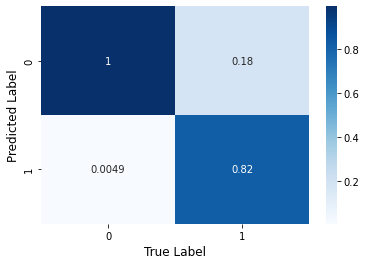

In [85]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.82

In [86]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False).style.hide_index()

Name,Predicted_Winner
Marina Abraham,0.000955
Vasanthi Krishnan,0.000875
Inaya Sulthana,0.000782
Rohit Sahni,0.000647
Sri Satya,0.000579
Bala Aditya,0.000495
Keerthi Bhat,0.000277
Faima,0.000268
Geetu Royal,0.000211
Srihan,0.000196


## Predicted Winner for Bigg Boss Telugu Season 6, as per Logistic Regression

In [87]:
# Predicted Winner for Bigg Boss Telugu 6 Season, as per LogisticRegression
winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)].style.hide_index()

Name,Predicted_Winner
Marina Abraham,0.000955


In [88]:
# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=2022).fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=500, random_state=2022)

In [89]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=100 accuracy 97.00

F1 Score - 98.06896858790269
Accuracy Score - 98.15668202764977


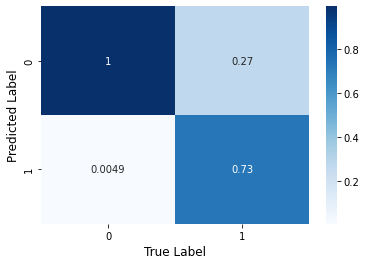

In [90]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.75

In [91]:
predicted_val_rf = rf.predict_proba(test)[:, 1]
winner_rf = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])], axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False).style.hide_index()

Name,Predicted_Winner
Bala Aditya,0.016000
Sri Satya,0.014000
Faima,0.010000
Geetu Royal,0.010000
Marina Abraham,0.008000
Inaya Sulthana,0.006000
Keerthi Bhat,0.006000
Revanth,0.006000
Rohit Sahni,0.006000
Adi Reddy,0.004000


## Predicted Winner for Bigg Boss Telugu Season 6, as per Random Forest

In [92]:
# Predicted Winner for Bigg Boss Telugu 6 Season, as per RandomForest
winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)].style.hide_index()

Name,Predicted_Winner
Bala Aditya,0.016000


## Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Hindi Bigg Boss Season16
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-hindi-season-16-winner

## Kannada Bigg Boss Season9
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-kannada-season-9-winner

## Tamil Bigg Boss Season6
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-tamil-season-6-winner

## Malayalam Bigg Boss Season4
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-malayalam-season-4-winner

## Marathi Bigg Boss Season4
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-marathi-season-4-winner

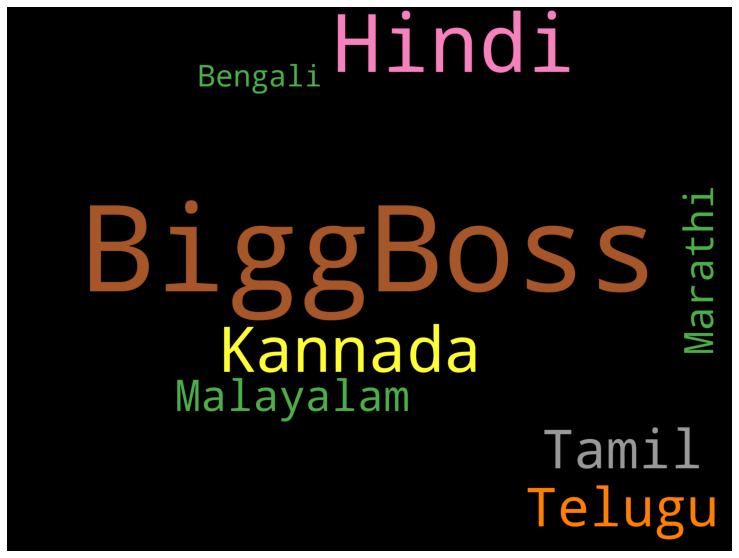

In [93]:
# Word cloud of Bigg Boss
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width=2000, height=1500, background_color='Black', colormap='Set1', collocations=False, random_state=2022).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

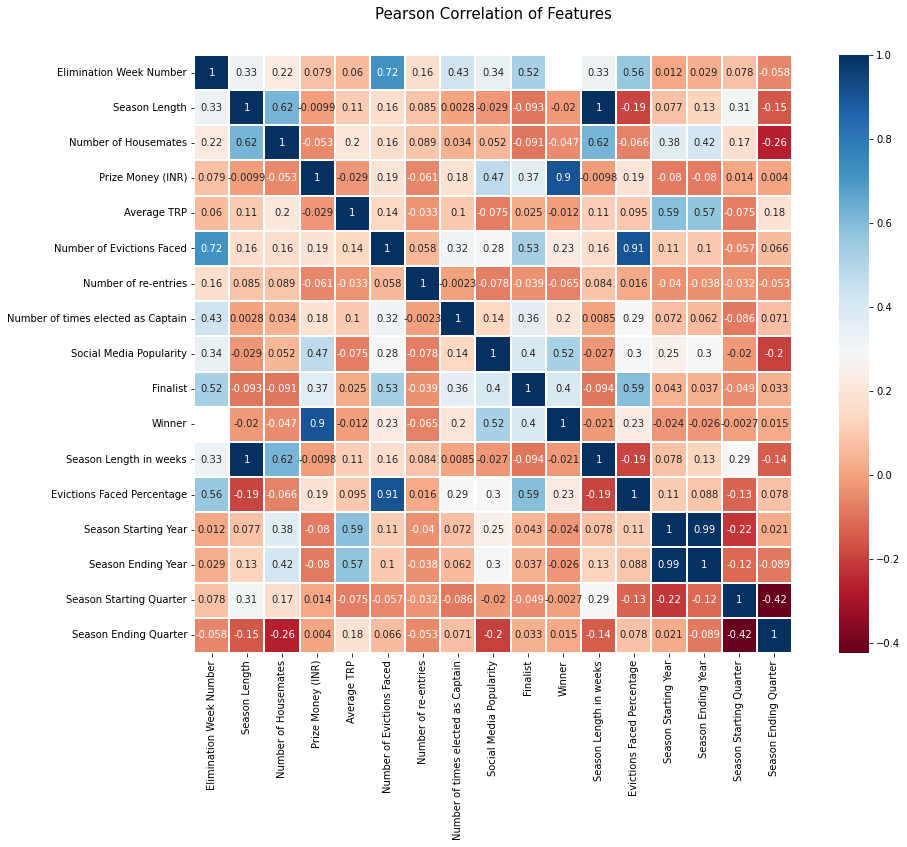

In [94]:
# Correlation matrix (Heatmap style)
corrmat = bigg_boss.corr()
f, ax = plt.subplots(figsize=(17, 11))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap="RdBu", linecolor='white', annot=True);

In [95]:
# Crosschecking Actor/Actress Gender
bigg_boss[bigg_boss['Profession'].str.contains('Act')].groupby('Gender')['Profession'].value_counts().unstack()
#bigg_boss.loc[(bigg_boss['Profession']=='Actress') & (bigg_boss['Gender']=='Male')]

Profession,Activist,Actor,Actor & Actress,Actress,Soap Actor,Soap Actress,Stage Actress
Gender,,,,,,,
Couple,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Female,4.0,NaN,NaN,206.0,NaN,78.0,2.0
Male,5.0,144.0,NaN,NaN,50.0,NaN,NaN


In [96]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
import plotly
print("plotly version: {}". format(plotly.__version__))

# Current versions
# numpy version: 1.21.6
# pandas version: 1.3.5
# matplotlib version: 3.5.3
# seaborn version: 0.11.2
# sklearn version: 1.0.2
# plotly version: 5.10.0

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.5.3
seaborn version: 0.11.2
sklearn version: 1.0.2
plotly version: 5.10.0
